# Detailed Analysis of Precision-Recall Tradeoffs

#### This notebook calculates PR curves for individual queries and then calculates the average PR curve across queries. Precision is interpolated based on common recall values to allow for meaningful averaging. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
## Change RESULTS_SUBFOLDER depending on which experiment is being evaluated
BASE_PATH = os.getenv("BASE_PATH")
print(f"BASE_PATH: {BASE_PATH}")

RESULTS_FOLDER = os.path.join(BASE_PATH, 'results')
RESULTS_SUBFOLDER = 'globalRGBhisto_Q14'

RESULTS_DIRECTORY = os.path.join(RESULTS_FOLDER, RESULTS_SUBFOLDER)
print(f"Results Directory: {RESULTS_DIRECTORY}")

BASE_PATH: C:\Users\JEMALOOL\git\cvpr-visual-search
Results Directory: C:\Users\JEMALOOL\git\cvpr-visual-search\results\globalRGBhisto_Q12


In [6]:
csv_files = [f for f in os.listdir(RESULTS_DIRECTORY) if f.startswith('precision_recall_stats') and f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file starting with 'per_query_ap' found in RESULTS_DIRECTORY.")

csv_path = os.path.join(RESULTS_DIRECTORY, csv_files[0])

df = pd.read_csv(csv_path)
print(df.head())

   query_index query_id  query_class  rank candidate_id  candidate_class  \
0          166   15_1_s           15     1        7_7_s                7   
1          166   15_1_s           15     2        7_5_s                7   
2          166   15_1_s           15     3        7_1_s                7   
3          166   15_1_s           15     4       8_21_s                8   
4          166   15_1_s           15     5       7_16_s                7   

   precision  recall  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  


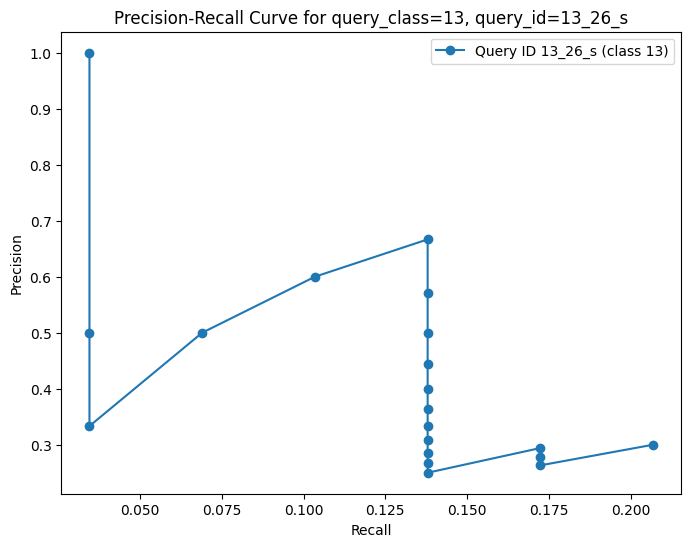

In [7]:
# Parameter: Change this to select different query_class
selected_query_class = 13

query_row = df[df['query_class'] == selected_query_class].iloc[0]
query_id = query_row['query_id']

query_data = df[df['query_id'] == query_id]

plt.figure(figsize=(8, 6))
plt.plot(query_data['recall'], query_data['precision'], marker='o', label=f'Query ID {query_id} (class {selected_query_class})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for query_class={selected_query_class}, query_id={query_id}')
plt.legend()
plt.savefig(os.path.join(RESULTS_DIRECTORY, (f"class_{selected_query_class}_pr_curve.png")), dpi=300, bbox_inches='tight')
plt.show()


#### Average PR Curve

In [8]:
all_curves = []
for query_id in df['query_id'].unique():
    data = df[df['query_id'] == query_id]
    recalls = np.array(data['recall'])
    precisions = np.array(data['precision'])
    # Sort by recall ascending
    sort_idx = np.argsort(recalls)
    recalls_sorted = recalls[sort_idx]
    precisions_sorted = precisions[sort_idx]
    all_curves.append((recalls_sorted, precisions_sorted))


In [9]:
def average_pr_curves(all_curves):
    # Create common recall levels for interpolation
    common_recalls = np.linspace(0, 1, 101)  # 0.00, 0.01, 0.02, ..., 1.00
    
    interpolated_precisions = []
    
    for recalls, precisions in all_curves:
        # Interpolate precision at common recall levels
        interp_prec = np.interp(common_recalls, recalls, precisions, 
                               left=precisions[0], right=0)
        interpolated_precisions.append(interp_prec)
    
    # Average precision at each recall level
    mean_precisions = np.mean(interpolated_precisions, axis=0)
    
    return common_recalls, mean_precisions

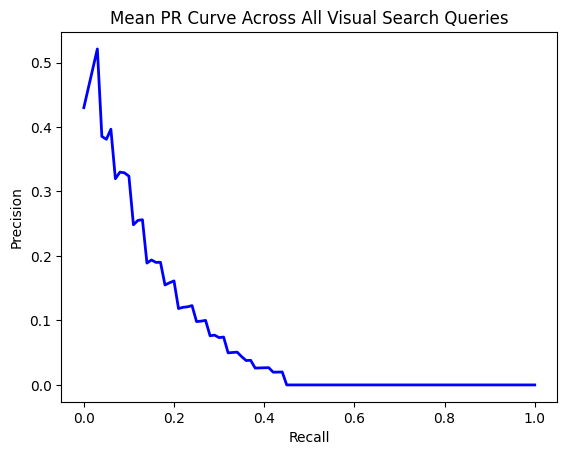

In [10]:
mean_recalls, mean_precisions = average_pr_curves(all_curves)

plt.plot(mean_recalls, mean_precisions, 'b-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean PR Curve Across All Visual Search Queries')
plt.savefig(os.path.join(RESULTS_DIRECTORY, "mean_pr_curve.png"), dpi=300, bbox_inches='tight')

# (Optional) Also display the plot in the notebook if desired
plt.show()